<a href="https://colab.research.google.com/github/theoVasilas/Diplomatic_incident/blob/simulation/Fed_3_1_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations

In [1]:
!pip install -q flwr[simulation] flwr-datasets[vision] torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.2/512.2 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.

In [2]:
from collections import OrderedDict, Counter
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset, logging
from datasets.utils.logging import disable_progress_bar

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, FedAdagrad
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset
from flwr.common import ndarrays_to_parameters, NDArrays, Scalar, Context


DEVICE = torch.device("cpu")  # Try "cuda" to train on GPU
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

Training on cpu
Flower 1.13.1 / PyTorch 2.5.1+cu121


# Dataloader

In [3]:
BATCH_SIZE = 32

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
def load_datasets(partition_id: int, num_partitions: int):

    fds = FederatedDataset(
        dataset="mnist",
        partitioners={"train": num_partitions}
    )

    pytorch_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    def apply_transforms(batch):
        batch["image"] = [pytorch_transforms(img) for img in batch["image"]]
        return batch

    partition = fds.load_partition(partition_id)
    # Divider : 80% train, 20% test
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
    #Apply Tranforms
    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(partition_train_test["train"], batch_size=BATCH_SIZE, shuffle=True )
    valloader = DataLoader(partition_train_test["test"], batch_size=BATCH_SIZE)

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE)

    return trainloader, valloader, testloader

### Histogram of the dataset


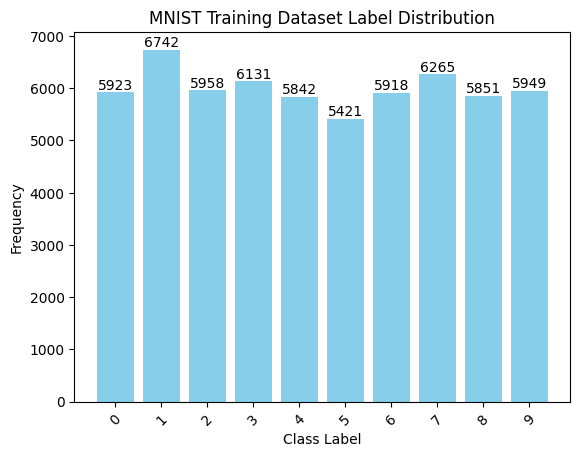

In [8]:
# Load the MNIST dataset
mnist = load_dataset("mnist")

# Construct histogram for training labels
all_labels = mnist["train"]["label"]
all_label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(all_label_counts.keys(), all_label_counts.values(), color="skyblue")
_ = plt.bar_label(bar)

# Plot formatting
plt.xticks(range(10), labels=[str(i) for i in range(10)], rotation=45)
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.title("MNIST Training Dataset Label Distribution")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


One Partition has 6000 examples.
One Partition has 4800 examples.
Entropy: 3.3182
Max Entropy (Uniform Distribution): 3.3219
Distribution Uniformity Ratio: 0.9989


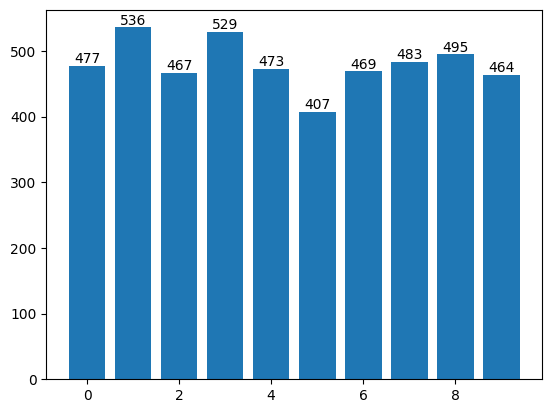

In [ ]:
num_partitions = 10  # Total number of participants
fds = FederatedDataset(
    dataset="mnist",
    partitioners={"train": num_partitions}
)

partition = fds.load_partition(0)
print(f"One Partition has {len(partition)} examples.")

# Divider : 80% train, 20% test
partition_train_test = partition.train_test_split(test_size=0.2, seed=42)
train_size = len(partition_train_test["train"])
print(f"One Partition has {train_size} examples.")

all_labels = partition_train_test["train"]["label"]

label_counts = Counter(all_labels)

# Visualize the histogram
bar = plt.bar(label_counts.keys(), label_counts.values())
_ = plt.bar_label(bar)

total_count = sum(label_counts.values())

# Calculate proportions
proportions = [count / total_count for count in label_counts.values()]

# Calculate entropy
entropy = -sum(p * np.log2(p) for p in proportions)
max_entropy = np.log2(len(label_counts))  # Maximum entropy for uniform distribution

print(f"Entropy: {entropy:.4f}")
print(f"Max Entropy (Uniform Distribution): {max_entropy:.4f}")
print(f"Distribution Uniformity Ratio: {entropy / max_entropy:.4f}")

so the data is IID

# Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
net = Net()
num_parameters = sum(value.numel() for value in net.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 44426


# Train Test func


In [ ]:
def train(net, trainloader, optimizer, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for batch in trainloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Metrics
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()

        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0

    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["image"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)

            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Federation

## set-get params


In [ ]:
def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    # replace the parameters
    net.load_state_dict(state_dict, strict=True)


def get_parameters(net) -> List[np.ndarray]:
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

## FlowerClient

In [ ]:
class FlowerClient(NumPyClient):
    def __init__(self, pid, net, trainloader, valloader):
        self.pid = pid  # partition ID of a client
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.pid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        # Read values from config
        server_round = config["server_round"]
        local_epochs = config["local_epochs"]

        # Use values provided by the config
        print(f"[Client {self.pid}, round {server_round}] fit, config: {config}")
        set_parameters(self.net, parameters)

        optim = torch.optim.SGD(self.net.parameters(), lr=0.01, momentum=0.9)
        train(self.net, self.trainloader,optim , epochs=local_epochs)
#============================================================================================
        # model_filename = f"federated_model_{server_round}.pth"
        # torch.save(net.state_dict(), model_filename)
        # print(f"Model saved as {model_filename}")
#============================================================================================
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):

        print(f"[Client {self.pid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)

        loss, accuracy = test(self.net, self.valloader)



        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(context: Context) -> Client:

    net = Net().to(DEVICE)

    partition_id = context.node_config["partition-id"]
    num_partitions = context.node_config["num-partitions"]

    trainloader, valloader, _ = load_datasets(partition_id, num_partitions)

    # print(f"FlowerClient is created")
    return FlowerClient(partition_id, net, trainloader, valloader).to_client()


# Create the ClientApp
client = ClientApp(client_fn=client_fn)

## Agregation Function

In [ ]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

In [ ]:
Agregation_history = []

def My_weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:

    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    losses = [num_examples * m.get("loss", 0.0) for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    accuracy = sum(accuracies) / sum(examples)
    loss = sum(losses) / sum(examples)

    # Save metrics to history
    Agregation_history.append({
        # "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    print(f"My_weighted_average -{accuracy} {loss} ")

    return {"accuracy": accuracy, "loss": loss}

## Server Evaluate metrics aggregation fn

In [ ]:
# The `evaluate` function will be called by Flower after every round
def evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    return loss, {"server_round": server_round, "accuracy": accuracy, "loss": loss}

In [ ]:
evaluation_history = []

def My_evaluate(
    server_round: int,
    parameters: NDArrays,
    config: Dict[str, Scalar],
) -> Optional[Tuple[float, Dict[str, Scalar]]]:

    net = Net().to(DEVICE)

    _, _, testloader = load_datasets(0, NUM_CLIENTS)

    set_parameters(net, parameters)  # Update model with the latest parameters

    loss, accuracy = test(net, testloader)

    print(f"Server-side evaluation loss {loss} / accuracy {accuracy}")

    # Save metrics to history
    evaluation_history.append({
        "round": server_round,
        "loss": loss,
        "accuracy": accuracy
    })

    model_filename = f"federated_model_{server_round}.pth"
    torch.save(net.state_dict(), model_filename)
    print(f"Model saved as {model_filename}")

    return loss, {"accuracy": accuracy}


## Server Fn Strategy

In [ ]:
def fit_config(server_round: int):
    config = {
        "server_round": server_round,  # The current round of federated learning
        "local_epochs": 1 ,
    }
    return config

In [ ]:
NUM_CLIENTS = 100

In [ ]:
NUM_ROUNDS = 10

In [ ]:
params = get_parameters(Net())

In [ ]:
def server_fn(context: Context) -> ServerAppComponents:
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit  = 1,
        fraction_evaluate = 1,
        min_fit_clients  =  5,
        min_evaluate_clients  = 2,
        min_available_clients = NUM_CLIENTS, # use all
        evaluate_fn = My_evaluate, # function used for validation dy server
        on_fit_config_fn  = fit_config,  # Pass the fit_config function
        # on_evaluate_config_fn,
        # accept_failures,
        initial_parameters  = ndarrays_to_parameters(params),
        evaluate_metrics_aggregation_fn =  My_weighted_average,
        # inplace,
    )

    config = ServerConfig(num_rounds = NUM_ROUNDS)

    return ServerAppComponents(strategy=strategy, config = config)


# Create the ServerApp
server = ServerApp(server_fn=server_fn)

## RUN


In [ ]:
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

DEBUG:flwr:Asyncio event loop already running.
INFO :      Starting Flower ServerApp, config: num_rounds=10, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
(pid=1218) 2024-11-18 16:58:19.332008: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=1218) 2024-11-18 1

Server-side evaluation loss 0.0721886756658554 / accuracy 0.0987
Model saved as federated_model_0.pth


(pid=1218) 2024-11-18 16:58:23.224595: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(ClientAppActor pid=1218) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=1218) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=1218) see the appropriate new directories, set the environment variable
(ClientAppActor pid=1218) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=1218) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=1218)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write
(pid=1217) 2024-11-18 16:58:20.005213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(

(ClientAppActor pid=1218) [Client 7, round 1] fit, config: {'server_round': 1, 'local_epochs': 1}
(ClientAppActor pid=1217) [Client 83, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 3x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(ClientAppActor pid=1218) [Client 13, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1218) [Client 88, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 66, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 41, round 1] fit, config: {'server_round': 1, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 55, round 1] fit, config: {'serve

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (1, 0.07172676692008972, {'accuracy': 0.1394}, 232.256595393)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.07172676692008972 / accuracy 0.1394
Model saved as federated_model_1.pth
(ClientAppActor pid=1218) [Client 26] evaluate, config: {}
(ClientAppActor pid=1218) [Client 75] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 77] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 41] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 50] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 54] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 91] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 27] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 12] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 57] evaluate,

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.1394166666666667 0.0 
(ClientAppActor pid=1217) [Client 0, round 2] fit, config: {'server_round': 2, 'local_epochs': 1}
(ClientAppActor pid=1217) [Client 8] evaluate, config: {}
(ClientAppActor pid=1218) [Client 90, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 96, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 56, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 88, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 1, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 74, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Clien

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (2, 0.07105273990631103, {'accuracy': 0.2093}, 639.3239681329999)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.07105273990631103 / accuracy 0.2093
Model saved as federated_model_2.pth
(ClientAppActor pid=1218) [Client 15] evaluate, config: {}
(ClientAppActor pid=1218) [Client 93, round 2] fit, config: {'server_round': 2, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1218) [Client 84] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 53] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 28] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 59] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 46] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 78] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 68] evaluate, config: {} [repeated 4x across cluster]
(Client

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.21599999999999986 0.0 
(ClientAppActor pid=1217) [Client 49, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=1218) [Client 97] evaluate, config: {}
(ClientAppActor pid=1217) [Client 77, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 1, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 64, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 74, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1217) [Client 38, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1217) [Client 55, round 3] fit, config: {'server_round': 3, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Cl

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (3, 0.06953631930351258, {'accuracy': 0.263}, 1047.023653526)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.06953631930351258 / accuracy 0.263
Model saved as federated_model_3.pth
(ClientAppActor pid=1218) [Client 26] evaluate, config: {}
(ClientAppActor pid=1217) [Client 59, round 3] fit, config: {'server_round': 3, 'local_epochs': 1}
(ClientAppActor pid=1218) [Client 83] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 52] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 37] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 55] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 90] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 86] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 66] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 51]

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.26541666666666675 0.0 
(ClientAppActor pid=1218) [Client 44, round 4] fit, config: {'server_round': 4, 'local_epochs': 1}
(ClientAppActor pid=1217) [Client 23] evaluate, config: {}
(ClientAppActor pid=1218) [Client 84, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 36, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 75, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 20, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 34, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1218) [Client 45, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1217) [C

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (4, 0.06467111406326294, {'accuracy': 0.4857}, 1455.032437569)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.06467111406326294 / accuracy 0.4857
Model saved as federated_model_4.pth
(ClientAppActor pid=1217) [Client 27] evaluate, config: {}
(ClientAppActor pid=1218) [Client 38, round 4] fit, config: {'server_round': 4, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1217) [Client 74] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 21] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 30] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 69] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 46] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 11] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 80] evaluate, config: {} [repeated 4x across cluster]
(Client

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


(ClientAppActor pid=1218) [Client 90] evaluate, config: {} [repeated 4x across cluster]
My_weighted_average -0.48283333333333334 0.0 
(ClientAppActor pid=1218) [Client 26, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=1218) [Client 62, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 32, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 90, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 35, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 64, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 14, round 5] fit, config: {'server_round': 5, 'local_epochs': 1} [repeated 4x across cluster]

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (5, 0.04484471033811569, {'accuracy': 0.6674}, 1864.2627496700002)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.04484471033811569 / accuracy 0.6674
Model saved as federated_model_5.pth
(ClientAppActor pid=1218) [Client 8] evaluate, config: {}
(ClientAppActor pid=1218) [Client 58, round 5] fit, config: {'server_round': 5, 'local_epochs': 1}
(ClientAppActor pid=1217) [Client 64] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 74] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 38] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 72] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 29] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 91] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 16] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 44] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 37

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.6492500000000001 0.0 
(ClientAppActor pid=1218) [Client 42, round 6] fit, config: {'server_round': 6, 'local_epochs': 1}
(ClientAppActor pid=1217) [Client 57] evaluate, config: {}
(ClientAppActor pid=1218) [Client 92, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 87, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 94, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1218) [Client 16, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1218) [Client 57, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 78, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1218) [Cl

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (6, 0.021290989711880683, {'accuracy': 0.8091}, 2272.557654162)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.021290989711880683 / accuracy 0.8091
Model saved as federated_model_6.pth
(ClientAppActor pid=1217) [Client 41] evaluate, config: {}
(ClientAppActor pid=1218) [Client 63, round 6] fit, config: {'server_round': 6, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1217) [Client 89] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 24] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 61] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 62] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 11] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 21] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 67] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 59] evaluate, config: {} [repeated 4x across cluster]
(Clie

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.7974166666666669 0.0 
(ClientAppActor pid=1217) [Client 17, round 7] fit, config: {'server_round': 7, 'local_epochs': 1}
(ClientAppActor pid=1217) [Client 98] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=1217) [Client 88, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 79, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 5, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 41, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 36, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1217) [Client 85, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 3x across cluster]
(

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (7, 0.01671361759006977, {'accuracy': 0.8512}, 2679.850982986)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.01671361759006977 / accuracy 0.8512
Model saved as federated_model_7.pth
(ClientAppActor pid=1217) [Client 17] evaluate, config: {}
(ClientAppActor pid=1217) [Client 34, round 7] fit, config: {'server_round': 7, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1218) [Client 69] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 23] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 27] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 18] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 91] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 30] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 75] evaluate, config: {} [repeated 4x across cluster]
(Client

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8441666666666668 0.0 
(ClientAppActor pid=1218) [Client 7, round 8] fit, config: {'server_round': 8, 'local_epochs': 1}
(ClientAppActor pid=1218) [Client 83] evaluate, config: {}
(ClientAppActor pid=1217) [Client 60, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 84, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 88, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 22, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 20, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 46, round 8] fit, config: {'server_round': 8, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1218) [Cli

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (8, 0.013299905429780483, {'accuracy': 0.8743}, 3086.138349814)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.013299905429780483 / accuracy 0.8743
Model saved as federated_model_8.pth
(ClientAppActor pid=1218) [Client 28] evaluate, config: {}
(ClientAppActor pid=1218) [Client 75] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 80] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 40] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 56] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 94] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 19] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 50] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 87] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 62] evaluate

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8629166666666664 0.0 
(ClientAppActor pid=1218) [Client 18, round 9] fit, config: {'server_round': 9, 'local_epochs': 1}
(ClientAppActor pid=1217) [Client 54] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=1217) [Client 98, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 45, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1218) [Client 83, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1217) [Client 47, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1218) [Client 70, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1217) [Client 72, round 9] fit, config: {'server_round': 9, 'local_epochs': 1} [repeated 3x across cluster]


INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (9, 0.011943857433646917, {'accuracy': 0.89}, 3497.923825787)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.011943857433646917 / accuracy 0.89
Model saved as federated_model_9.pth
(ClientAppActor pid=1217) [Client 3] evaluate, config: {}
(ClientAppActor pid=1218) [Client 35] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 22] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 29] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 18] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 10] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=1217) [Client 88] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=1217) [Client 89] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 55] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 56] evaluate, config: {} [repeated 3x across cluster]
(ClientAppActor pid=1217) [Client 68] evaluate, 

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 100 clients (out of 100)


My_weighted_average -0.8798333333333334 0.0 
(ClientAppActor pid=1217) [Client 41, round 10] fit, config: {'server_round': 10, 'local_epochs': 1}
(ClientAppActor pid=1218) [Client 63] evaluate, config: {}
(ClientAppActor pid=1217) [Client 47, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1218) [Client 98, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 1, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 74, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 3x across cluster]
(ClientAppActor pid=1218) [Client 11, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 60, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 4x across cluster]
(ClientAppActor 

INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      fit progress: (10, 0.010605307241529227, {'accuracy': 0.8994}, 3916.5016214969996)
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)


Server-side evaluation loss 0.010605307241529227 / accuracy 0.8994
Model saved as federated_model_10.pth
(ClientAppActor pid=1218) [Client 7] evaluate, config: {}
(ClientAppActor pid=1218) [Client 97, round 10] fit, config: {'server_round': 10, 'local_epochs': 1} [repeated 2x across cluster]
(ClientAppActor pid=1217) [Client 95] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1218) [Client 93] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 37] evaluate, config: {} [repeated 2x across cluster]
(ClientAppActor pid=1217) [Client 94] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 83] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 52] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 30] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=1217) [Client 27] evaluate, config: {} [repeated 4x across cluster]
(Cl

INFO :      aggregate_evaluate: received 100 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 4110.01s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.07638917601108554
INFO :      		round 2: 0.07568218704064687
INFO :      		round 3: 0.0740942249099414
INFO :      		round 4: 0.06900924653808274
INFO :      		round 5: 0.048342982242504766
INFO :      		round 6: 0.02363182738174995
INFO :      		round 7: 0.018805093519389623
INFO :      		round 8: 0.015262411387016377
INFO :      		round 9: 0.013719038127611084
INFO :      		round 10: 0.012230183953419332
INFO :      	History (loss, centralized):
INFO :      		round 0: 0.0721886756658554
INFO :      		round 1: 0.07172676692008972
INFO :      		round 2: 0.07105273990631103
INFO :      		round 3: 0.06953631930351258
INFO :      		round 4: 0.06467111406326294
INFO :      		round 5: 0.04484471033811569
INFO :      		round 6: 0.021290989711880683
INFO :      		round 7: 0.016

My_weighted_average -0.8914166666666666 0.0 
(ClientAppActor pid=1218) [Client 64] evaluate, config: {} [repeated 3x across cluster]


(ClientAppActor pid=1217) /usr/local/lib/python3.10/dist-packages/jupyter_client/connect.py:28: DeprecationWarning: Jupyter is migrating its paths to use standard platformdirs
(ClientAppActor pid=1217) given by the platformdirs library.  To remove this warning and
(ClientAppActor pid=1217) see the appropriate new directories, set the environment variable
(ClientAppActor pid=1217) `JUPYTER_PLATFORM_DIRS=1` and then run `jupyter --paths`.
(ClientAppActor pid=1217) The use of platformdirs will be the default in `jupyter_core` v6
(ClientAppActor pid=1217)   from jupyter_core.paths import jupyter_data_dir, jupyter_runtime_dir, secure_write


# plots

In [ ]:
net.load_state_dict(torch.load("federated_model_3.pth"))
net.eval()
_, valloader, _ = load_datasets(0, 1)
loss, accuracy = test(net, valloader)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-23-ee3b8fdb1208>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted b

Validation Loss: 0.0613
Validation Accuracy: 0.49%


In [ ]:
Agregation_history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'loss': 0.0, 'accuracy': 0.25649999999999995},
 {'loss': 0.0, 'accuracy': 0.4214166666666667},
 {'loss': 0.0, 'accuracy': 0.4860000000000001},
 {'loss': 0.0, 'accuracy': 0.6928333333333333},
 {'loss': 0.0, 'accuracy': 0.7739999999999999},
 {'loss': 0.0, 'accuracy': 0.8179166666666666},
 {'loss': 0.0, 'accuracy': 0.8434166666666668},
 {'loss': 0.0, 'accuracy': 0.866666666666667},
 {'loss': 0.0, 'accuracy': 0.8797500000000004},
 {'loss': 0.0, 'accuracy': 0.8925000000000003}]

In [ ]:
evaluation_history

[{'round': 0, 'loss': 0.07253411319255829, 'accuracy': 0.0764},
 {'round': 1, 'loss': 0.0710661331653595, 'accuracy': 0.2669},
 {'round': 2, 'loss': 0.06879100794792176, 'accuracy': 0.4342},
 {'round': 3, 'loss': 0.061089597964286806, 'accuracy': 0.51},
 {'round': 4, 'loss': 0.037932675898075106, 'accuracy': 0.7148},
 {'round': 5, 'loss': 0.02384209318459034, 'accuracy': 0.7889},
 {'round': 6, 'loss': 0.01827797512114048, 'accuracy': 0.8276},
 {'round': 7, 'loss': 0.015152507933974267, 'accuracy': 0.854},
 {'round': 8, 'loss': 0.013269370909035206, 'accuracy': 0.8751},
 {'round': 9, 'loss': 0.011686096108704806, 'accuracy': 0.8902},
 {'round': 10, 'loss': 0.010579131610691548, 'accuracy': 0.9026}]

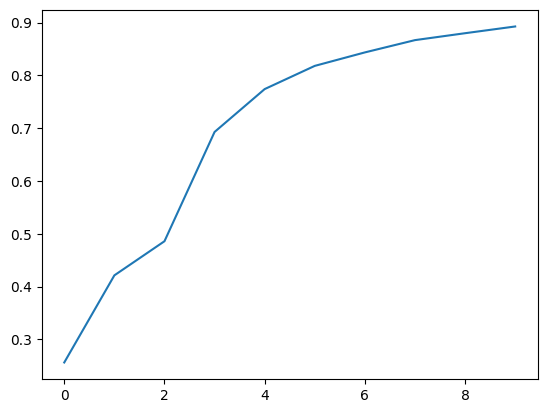

In [ ]:
accuracy_values = [d['accuracy'] for d in Agregation_history]
plt.plot(accuracy_values)
plt.show()

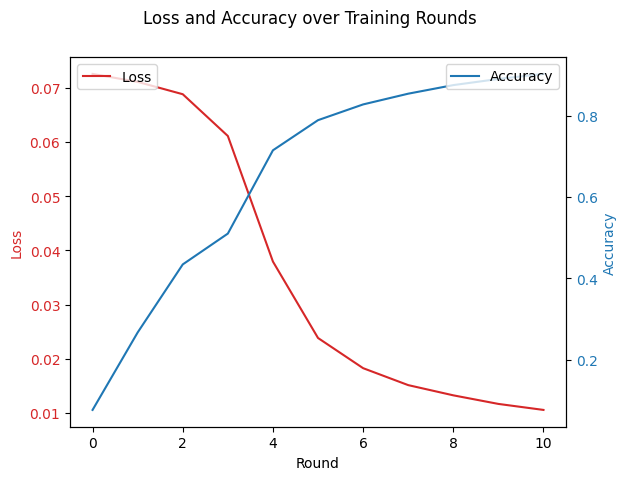

In [ ]:
rounds = [entry["round"] for entry in evaluation_history]
loss = [entry["loss"] for entry in evaluation_history]
accuracy = [entry["accuracy"] for entry in evaluation_history]

fig, ax1 = plt.subplots()

# Plot loss on the first y-axis
ax1.set_xlabel("Round")
ax1.set_ylabel("Loss", color="tab:red")
ax1.plot(rounds, loss, color="tab:red", label="Loss")
ax1.tick_params(axis="y", labelcolor="tab:red")

# Create a second y-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:blue")
ax2.plot(rounds, accuracy, color="tab:blue", label="Accuracy")
ax2.tick_params(axis="y", labelcolor="tab:blue")

# Title and legend
fig.suptitle("Loss and Accuracy over Training Rounds")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")

# Show the plot
plt.show()
